### e-commerce 데이터 LTV 분석 및 예측

#### 1.0 데이터 로드

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
folder = 'C:/Users/su/OneDrive - 청주대학교 (1)/datasets/before/2023'
file_name = '[2023_07_26]E_Commerce_Data'
e_data = 'data.csv'

In [4]:
encoding="unicode_escape"
encoding="ISO-8859-1"
e_data = pd.read_csv(os.path.join(folder, file_name, e_data), encoding=encoding)

#### 2.0 LTV 분석

##### 2.1 데이터 정보 확인

In [5]:
e_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
e_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


##### 2.2 데이터 전처리

In [7]:
# type 변경
e_data['InvoiceDate'] = pd.to_datetime(e_data['InvoiceDate'])
print(e_data['InvoiceDate'])

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 541909, dtype: datetime64[ns]


In [8]:
# 취소된 주문 제거(수량이 1이상인 것만 데이터 남김)
e_data = e_data[e_data['Quantity'] > 0]
e_data.shape

(531285, 8)

In [9]:
# 주문고객번호가 있는 것만 남김
e_data = e_data.dropna(axis=0, subset=['CustomerID'])
e_data.shape

(397924, 8)

In [10]:
# 1달 간격으로 데이터 맞춤
print(f"Invoice Date Range: {e_data['InvoiceDate'].min()} - {e_data['InvoiceDate'].max()}")
e_data = e_data[e_data['InvoiceDate'] < '2011-12-01']
e_data.shape

Invoice Date Range: 2010-12-01 08:26:00 - 2011-12-09 12:50:00


(380620, 8)

In [11]:
# Sales column 추가
e_data['Sales'] = e_data['Quantity'] * e_data['UnitPrice']
e_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [12]:
# box plot iqr
def iqr_func(x):
    q3, q1 = np.percentile(x, [75, 25])
    iqr = q3 - q1
    return iqr
# range
def range_func(x):
    max_val = max(x)
    min_val = min(x)
    range_val = max_val - min_val
    return range_val
# interval
def date_interval_func(x):
    first_date = min(x)
    last_date = max(x)

    date_diff = (last_date - first_date)

    return date_diff

In [13]:
# 총구입 금액 계산.
orders_df = e_data.groupby(['CustomerID', 'InvoiceNo']).agg({
    'Sales': sum,
    'InvoiceDate': max
})

orders_df.head()

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00

In [14]:
# 집계함수
def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()
    # return x.unique()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [15]:
# 고객 id별로 레코드를 다시 그룹화하고 sales, invoicedate 집계

summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency],
})
print(summary_df.shape)
summary_df.head()

(4298, 9)


Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000     1   
12347.0       382.52   1294.32   4085.18    680.863333     6   
12348.0       227.44    892.80   1797.24    449.310000     4   
12349.0      1757.55   1757.55   1757.55   1757.550000     1   
12350.0       334.40    334.40    334.40    334.400000     1   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   

                               
           purchase_frequency  
CustomerID                     
12346.0                   0.0  
12347.0                  54.5  
12348.0                  70.5  
12349.0                   0.0  
12350.0                   0.0

In [16]:
# 인덱스 제거 및 column 재배치
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]
summary_df = summary_df.reset_index()
print(summary_df.shape)
summary_df.head()

(4298, 10)


,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.0
1,12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.5
2,12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.5
3,12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.0
4,12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.0


#### 2.3 데이터 시각화

In [17]:
# 2번 이상구매한 고객
summary_df_fin = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]
summary_df_fin.shape

(2692, 10)

Text(0.5, 1.0, 'the repeat customers')

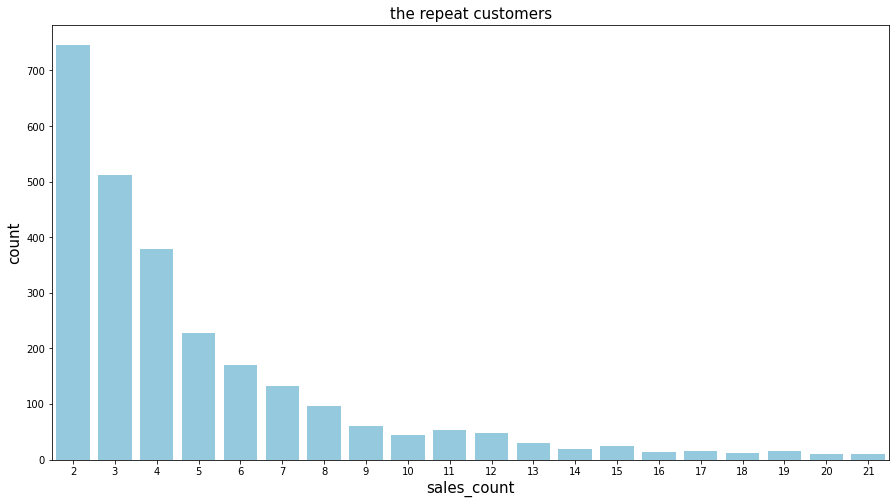

In [18]:
# 고객의 반복 구매 횟수
sales_avg = summary_df_fin.groupby('sales_count').count().sales_avg[:20]
plt.figure(figsize=(15, 8))
ax = sns.barplot(
    x=sales_avg.index,
    y=sales_avg.values,
    color='skyblue'
    )
plt.xlabel('sales_count', size=15)
plt.ylabel('count', size=15)
plt.title('the repeat customers', size=15)

- 2회 구매가 가장 많고, 대다수의 고객은 9회 이내로 구매함.

Text(0.5, 1.0, 'purchase frequency')

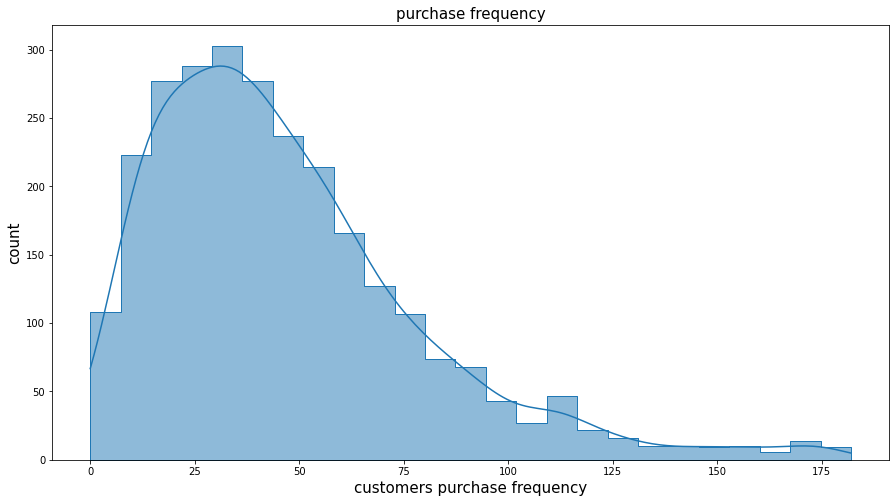

In [19]:
# 고객의 반복 구매 간격의 평균 일수
# 이는 고객이 구매를 반복한 빈도를 과거에 얼마나 자주 했는지를 보여주는 전체적인 보기입니다.

invoicedate_purchase_frequency = summary_df_fin['invoicedate_purchase_frequency']
plt.figure(figsize=(15, 8))
ax = sns.histplot(
    x=invoicedate_purchase_frequency.values,
    bins=25,
    kde=True,
    element='step',
    stat='count',
    
    # cumulative=True,
    )
plt.xlabel('customers purchase frequency', size=15)
plt.ylabel('count', size=15)
plt.title('purchase frequency', size=15)


- 25일에서 50일 사이로 구매를 반복한 횟수가 제일 많음

#### 2.4 CLTV 분석

#### simple Customer life time value CLTV : 평균 주문 값 * 평균 고객의 구매 빈도 / 평균 고객 수명

In [20]:
summary_df_fin[['sales_avg', 'sales_count', 'invoicedate_purchase_frequency']]

,sales_avg,sales_count,invoicedate_purchase_frequency
1,680.863333,6,54.500000
2,449.310000,4,70.500000
5,313.255000,8,32.500000
9,937.143333,3,100.666667
12,1593.145000,4,68.500000
...,...,...,...
4286,141.575000,2,114.000000
4287,542.140000,5,40.200000
4288,76.500000,2,81.000000
4296,125.792000,15,21.800000


In [21]:
# 구매 빈도 = 전체 고객의 총 구매 횟수 / 고객의 수 = 약 4.131로 평균적으로 고객마다 4번의 구매를 하였음을 확인
purchase_frequency = sum(summary_df.sales_count) / summary_df.shape[0]
purchase_frequency

4.13168915774779

In [22]:
# 반복하여 구매한 고객의 비율 = 1회 이상 구매한 고객의 수 / 전체 고객의 수 = 약 0.642
repeat_rate=summary_df[summary_df.sales_count > 1].shape[0]/summary_df.shape[0]
repeat_rate

0.6419264774313634

In [23]:
# 가입 해지율 = 반복하여 구매하지 않은 고객의 비율 = 1 - repeat rate = 약 0.358
churn_rate = 1-repeat_rate
churn_rate

0.35807352256863656

In [24]:
# Profit Margin
# 순이익률을 약 10%로 잡아 고객별로 구매 금액의 10%를 profit_margin column으로 생성
summary_df['profit_margin'] = summary_df.sales_sum * 0.10
summary_df.head()

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.0,7718.360
1,12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.5,408.518
2,12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.5,179.724
3,12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.0,175.755
4,12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.0,33.440


In [25]:
# Customer Value
# 고객 가치(customer value) = 고객별 평균 구매 금액 * 총 고객의 구매 빈도 / 가입해지율
summary_df['CV']=(summary_df['sales_avg']*purchase_frequency)/churn_rate
summary_df.head()

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin,CV
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.0,7718.360,890595.431319
1,12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.5,408.518,7856.251510
2,12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.5,179.724,5184.435984
3,12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.0,175.755,20279.774464
4,12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.0,33.440,3858.528395


In [26]:
#Customer Lifetime Value
# LTV(CLTV) = customer value * profit_margin
summary_df['customer_lifetime_value']=summary_df['CV']*summary_df['profit_margin']
summary_df.head()

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin,CV,customer_lifetime_value
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.0,7718.360,890595.431319,6.873936e+09
1,12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.5,408.518,7856.251510,3.209420e+06
2,12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.5,179.724,5184.435984,9.317676e+05
3,12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.0,175.755,20279.774464,3.564272e+06
4,12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.0,33.440,3858.528395,1.290292e+05


In [27]:
# 내림차순 정렬 상위 10명
summary_df.sort_values(by=['customer_lifetime_value'], ascending=False).head(10)

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin,CV,customer_lifetime_value
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.000000,7718.360,890595.431319,6.873936e+09
4162,18102.0,80.60,22206.00,248171.76,4353.890526,57,2010-12-07 16:42:00,2011-11-28 12:55:00,355,6.228070,24817.176,50238.068854,1.246767e+09
1672,14646.0,0.00,20277.92,268478.00,3781.380282,71,2010-12-20 10:09:00,2011-11-23 11:06:00,338,4.760563,26847.800,43632.066954,1.171425e+09
3693,17450.0,34.56,31698.16,192988.39,4288.630889,45,2010-12-07 09:23:00,2011-11-29 09:56:00,357,7.933333,19298.839,49485.059990,9.550042e+08
54,12415.0,61.20,22775.93,124914.53,5948.310952,21,2011-01-06 11:12:00,2011-11-15 14:22:00,313,14.904762,12491.453,68635.546389,8.573577e+08
2478,15749.0,7837.50,21535.90,44534.30,14844.766667,3,2011-01-11 12:55:00,2011-04-18 13:20:00,97,32.333333,4453.430,171288.737145,7.628224e+08
1992,15098.0,297.00,38970.00,39916.50,13305.500000,3,2011-06-10 15:22:00,2011-06-10 15:33:00,0,0.000000,3991.650,153527.660169,6.128287e+08
1320,14156.0,34.68,16774.72,117379.63,2134.175091,55,2010-12-03 11:48:00,2011-11-30 10:54:00,361,6.563636,11737.963,24625.523888,2.890535e+08
3736,17511.0,31.00,7059.54,83683.06,2885.622759,29,2010-12-01 10:19:00,2011-11-23 10:31:00,357,12.310345,8368.306,33296.224137,2.786330e+08
1276,14096.0,21.84,8425.54,56228.81,3514.300625,16,2011-08-30 10:49:00,2011-11-28 15:54:00,90,5.625000,5622.881,40550.325210,2.280097e+08


In [28]:
# 2회 이상 구매 고객, 정렬
summary_df[(summary_df.sales_count>1) & (summary_df.invoicedate_purchase_duration>1)].sort_values(by=['customer_lifetime_value'], ascending=False).head(10)

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin,CV,customer_lifetime_value
4162,18102.0,80.60,22206.00,248171.76,4353.890526,57,2010-12-07 16:42:00,2011-11-28 12:55:00,355,6.228070,24817.176,50238.068854,1.246767e+09
1672,14646.0,0.00,20277.92,268478.00,3781.380282,71,2010-12-20 10:09:00,2011-11-23 11:06:00,338,4.760563,26847.800,43632.066954,1.171425e+09
3693,17450.0,34.56,31698.16,192988.39,4288.630889,45,2010-12-07 09:23:00,2011-11-29 09:56:00,357,7.933333,19298.839,49485.059990,9.550042e+08
54,12415.0,61.20,22775.93,124914.53,5948.310952,21,2011-01-06 11:12:00,2011-11-15 14:22:00,313,14.904762,12491.453,68635.546389,8.573577e+08
2478,15749.0,7837.50,21535.90,44534.30,14844.766667,3,2011-01-11 12:55:00,2011-04-18 13:20:00,97,32.333333,4453.430,171288.737145,7.628224e+08
1320,14156.0,34.68,16774.72,117379.63,2134.175091,55,2010-12-03 11:48:00,2011-11-30 10:54:00,361,6.563636,11737.963,24625.523888,2.890535e+08
3736,17511.0,31.00,7059.54,83683.06,2885.622759,29,2010-12-01 10:19:00,2011-11-23 10:31:00,357,12.310345,8368.306,33296.224137,2.786330e+08
1276,14096.0,21.84,8425.54,56228.81,3514.300625,16,2011-08-30 10:49:00,2011-11-28 15:54:00,90,5.625000,5622.881,40550.325210,2.280097e+08
1271,14088.0,33.16,10584.77,50491.81,3883.985385,13,2011-01-21 13:07:00,2011-11-29 16:16:00,312,24.000000,5049.181,44815.992502,2.262841e+08
3144,16684.0,149.46,13760.02,61251.58,2268.577037,27,2010-12-16 17:34:00,2011-11-28 15:35:00,346,12.814815,6125.158,26176.342446,1.603342e+08


In [29]:
# 하위 구매 고객 정렬
summary_df.sort_values(by=['customer_lifetime_value'], ascending=False).tail(10)

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin,CV,customer_lifetime_value
713,13307.0,15.00,15.00,15.00,15.00,1,2011-08-11 17:14:00,2011-08-11 17:14:00,0,0.0,1.500,173.079922,259.619883
2533,15823.0,15.00,15.00,15.00,15.00,1,2010-12-02 15:08:00,2010-12-02 15:08:00,0,0.0,1.500,173.079922,259.619883
3925,17763.0,15.00,15.00,15.00,15.00,1,2011-03-21 14:25:00,2011-03-21 14:25:00,0,0.0,1.500,173.079922,259.619883
3290,16878.0,13.30,13.30,13.30,13.30,1,2011-09-16 17:39:00,2011-09-16 17:39:00,0,0.0,1.330,153.464198,204.107383
4060,17956.0,12.75,12.75,12.75,12.75,1,2011-04-04 13:47:00,2011-04-04 13:47:00,0,0.0,1.275,147.117934,187.575365
1776,14792.0,6.20,6.20,6.20,6.20,1,2011-10-07 09:19:00,2011-10-07 09:19:00,0,0.0,0.620,71.539701,44.354615
2986,16454.0,1.00,5.90,6.90,3.45,2,2011-10-06 16:57:00,2011-10-26 11:40:00,19,9.5,0.690,39.808382,27.467784
3185,16738.0,3.75,3.75,3.75,3.75,1,2011-02-15 09:46:00,2011-02-15 09:46:00,0,0.0,0.375,43.269981,16.226243
2980,16446.0,2.90,2.90,2.90,2.90,1,2011-05-18 09:52:00,2011-05-18 09:52:00,0,0.0,0.290,33.462118,9.704014
676,13256.0,0.00,0.00,0.00,0.00,1,2011-11-25 15:57:00,2011-11-25 15:57:00,0,0.0,0.000,0.000000,0.000000


In [30]:
# 2회 이상 하위 구매 고객 정렬
summary_df[(summary_df.sales_count>1) & (summary_df.invoicedate_purchase_duration>1)].sort_values(by=['customer_lifetime_value'], ascending=False).tail(10)

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin,CV,customer_lifetime_value
3025,16506.0,35.10,55.20,90.30,45.150000,2,2011-10-30 15:50:00,2011-11-20 12:17:00,20,10.000000,9.030,520.970565,4704.364205
1805,14836.0,3.00,76.05,102.45,34.150000,3,2011-11-09 13:26:00,2011-11-29 16:45:00,20,6.666667,10.245,394.045289,4036.993987
3392,17024.0,25.00,39.60,95.85,31.950000,3,2011-07-05 09:31:00,2011-10-25 13:47:00,112,37.333333,9.585,368.660234,3533.608342
1772,14785.0,37.92,39.48,77.40,38.700000,2,2011-11-24 13:40:00,2011-11-29 13:21:00,4,2.000000,7.740,446.546199,3456.267579
967,13666.0,20.40,43.65,84.65,28.216667,3,2011-02-25 13:05:00,2011-10-10 15:39:00,227,75.666667,8.465,325.582564,2756.056408
2564,15863.0,9.20,59.64,68.84,34.420000,2,2011-05-31 11:36:00,2011-11-14 12:49:00,167,83.500000,6.884,397.160728,2734.054450
1698,14682.0,20.80,31.20,52.00,26.000000,2,2011-05-22 12:51:00,2011-06-05 12:12:00,13,6.500000,5.200,300.005198,1560.027031
4116,18037.0,2.10,31.30,70.02,11.670000,6,2010-12-12 16:20:00,2011-07-08 13:39:00,207,34.500000,7.002,134.656179,942.862568
3960,17816.0,5.10,16.21,36.56,9.140000,4,2010-12-09 14:10:00,2011-11-03 11:34:00,328,82.000000,3.656,105.463366,385.574065
2986,16454.0,1.00,5.90,6.90,3.450000,2,2011-10-06 16:57:00,2011-10-26 11:40:00,19,9.500000,0.690,39.808382,27.467784


#### 2.5 그룹별 분석

##### 2.5.1 데이터 정규화

In [31]:
# minmax 로 정규화 및 cltv column 생성
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(summary_df[["customer_lifetime_value"]])
summary_df["scaled_cltv"] = scaler.transform(summary_df[["customer_lifetime_value"]])
summary_df.sort_values(by="scaled_cltv", ascending=False).head()

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin,CV,customer_lifetime_value,scaled_cltv
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.000000,7718.360,890595.431319,6.873936e+09,1.000000
4162,18102.0,80.60,22206.00,248171.76,4353.890526,57,2010-12-07 16:42:00,2011-11-28 12:55:00,355,6.228070,24817.176,50238.068854,1.246767e+09,0.181376
1672,14646.0,0.00,20277.92,268478.00,3781.380282,71,2010-12-20 10:09:00,2011-11-23 11:06:00,338,4.760563,26847.800,43632.066954,1.171425e+09,0.170415
3693,17450.0,34.56,31698.16,192988.39,4288.630889,45,2010-12-07 09:23:00,2011-11-29 09:56:00,357,7.933333,19298.839,49485.059990,9.550042e+08,0.138931
54,12415.0,61.20,22775.93,124914.53,5948.310952,21,2011-01-06 11:12:00,2011-11-15 14:22:00,313,14.904762,12491.453,68635.546389,8.573577e+08,0.124726


##### 2.5.2 데이터 이산화

In [32]:
summary_df["segment"] = pd.qcut(summary_df["scaled_cltv"], 4, labels=["D", "C", "B", "A"])
summary_df.head(10)

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,profit_margin,CV,customer_lifetime_value,scaled_cltv,segment
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.000000,7718.360,890595.431319,6.873936e+09,1.000000,A
1,12347.0,382.52,1294.32,4085.18,680.863333,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.500000,408.518,7856.251510,3.209420e+06,0.000467,A
2,12348.0,227.44,892.80,1797.24,449.310000,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.500000,179.724,5184.435984,9.317676e+05,0.000136,A
3,12349.0,1757.55,1757.55,1757.55,1757.550000,1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.000000,175.755,20279.774464,3.564272e+06,0.000519,A
4,12350.0,334.40,334.40,334.40,334.400000,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.000000,33.440,3858.528395,1.290292e+05,0.000019,C
5,12352.0,120.33,840.30,2506.04,313.255000,8,2011-02-16 12:33:00,2011-11-03 14:37:00,260,32.500000,250.604,3614.543398,9.058190e+05,0.000132,A
6,12353.0,89.00,89.00,89.00,89.000000,1,2011-05-19 17:47:00,2011-05-19 17:47:00,0,0.000000,8.900,1026.940871,9.139774e+03,0.000001,D
7,12354.0,1079.40,1079.40,1079.40,1079.400000,1,2011-04-21 13:11:00,2011-04-21 13:11:00,0,0.000000,107.940,12454.831189,1.344374e+06,0.000196,A
8,12355.0,459.40,459.40,459.40,459.400000,1,2011-05-09 13:49:00,2011-05-09 13:49:00,0,0.000000,45.940,5300.861079,2.435216e+05,0.000035,B
9,12356.0,58.35,2271.62,2811.43,937.143333,3,2011-01-18 09:50:00,2011-11-17 08:40:00,302,100.666667,281.143,10813.379671,3.040106e+06,0.000442,A


##### 2.5.3 segment별 분석

In [33]:
summary_df[["sales_count", "sales_sum", "customer_lifetime_value", "scaled_cltv"]].sort_values(by="scaled_cltv",ascending=False).head()
summary_df.groupby('segment')[['sales_count','sales_sum','customer_lifetime_value','scaled_cltv']].agg({'count','mean','sum'})

sales_count                    sales_sum                     \
                sum count      mean          sum count         mean   
segment                                                               
D              1616  1075  1.503256   200968.550  1075   186.947488   
C              2451  1074  2.282123   532103.043  1074   495.440450   
B              4061  1074  3.781192  1188642.290  1074  1106.743287   
A              9630  1075  8.958140  6471501.231  1075  6020.001145   

        customer_lifetime_value                     scaled_cltv        \
                            sum count          mean         sum count   
segment                                                                 
D                  3.420141e+07  1075  3.181527e+04    0.004976  1075   
C                  1.499415e+08  1074  1.396103e+05    0.021813  1074   
B                  4.610260e+08  1074  4.292607e+05    0.067069  1074   
A                  1.861315e+10  1075  1.731456e+07    2.707787  1075   

                   
             mean  
segment            
D        0.000005  
C        0.000020  
B        0.000062  
A        0.002519

#### 3.0 3달 간격의 CLV 예측 

In [34]:
# 3달 간격으로 빈도수 결정
clv_freq = '3M'

# CustomerID로 묶음.
# Sales column의 집계.

data_df = orders_df.reset_index().groupby([
    'CustomerID',
    pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
    'Sales': [sum, groupby_mean, groupby_count],
})

data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1
1,12347.0,2010-12-31,711.79,711.790,1
2,12347.0,2011-03-31,475.39,475.390,1
3,12347.0,2011-06-30,1018.77,509.385,2
4,12347.0,2011-09-30,584.91,584.910,1


In [35]:
# invoicedate를 년-월-일로 변경
data_df['InvoiceDate'] = data_df['InvoiceDate'].dt.strftime('%Y-%m-%d')
data_df['InvoiceDate']

0       2011-03-31
1       2010-12-31
2       2011-03-31
3       2011-06-30
4       2011-09-30
           ...    
9215    2011-06-30
9216    2011-09-30
9217    2011-12-31
9218    2011-06-30
9219    2011-12-31
Name: InvoiceDate, Length: 9220, dtype: object

In [37]:
# InvoiceDate 년-월-일로 데이터 분류
date_month_map = {
    x : f'M_{i+1}' for i, x in enumerate(
        sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
    )
}
date_month_map

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

In [38]:
# M column 생성. segmentation.
data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[x])
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1,M_4
1,12347.0,2010-12-31,711.79,711.790,1,M_5
2,12347.0,2011-03-31,475.39,475.390,1,M_4
3,12347.0,2011-06-30,1018.77,509.385,2,M_3
4,12347.0,2011-09-30,584.91,584.910,1,M_2
5,12347.0,2011-12-31,1294.32,1294.320,1,M_1
6,12348.0,2010-12-31,892.80,892.800,1,M_5
7,12348.0,2011-03-31,227.44,227.440,1,M_4
8,12348.0,2011-06-30,367.00,367.000,1,M_3
9,12348.0,2011-09-30,310.00,310.000,1,M_2


#### 3.1 데이터셋 만들기.

In [39]:
# 타겟 데이터인 M_1 제외
features_df = pd.pivot_table(
    data_df.loc[data_df['M'] != 'M_1'], 
    values=['sales_sum', 'sales_avg', 'sales_count'],
    # values=['sales_avg'],
    # values=['sales_sum'],
    # values=['sales_count'],
    columns='M', 
    index='CustomerID'
)

features_df.columns = ['_'.join(col) for col in features_df.columns]

# nan값 채우기
features_df = features_df.fillna(0)
features_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
12347.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
12352.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00
18281.0,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00
18282.0,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00


In [40]:
# M_1은 타겟 데이터이므로 추후 데이터를 합치기 위해 table화.
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['CustomerID', 'sales_sum']
]

# 컬럼 이름 변경
response_df.columns = ['CustomerID', 'CLV_'+clv_freq]
response_df

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67
...,...,...
9207,18274.0,175.92
9208,18276.0,335.86
9209,18277.0,110.38
9217,18283.0,766.21


In [41]:
# features_df 와 response_df를 CustomerID로 merge
sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='CustomerID',
    how='left'
)

# nan 채우기
sample_set_df = sample_set_df.fillna(0)

sample_set_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00,18280.0,0.00
NaN,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00,18281.0,0.00
NaN,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00,18282.0,0.00
9217.0,92.696667,131.170,105.966667,0.00,3.0,4.0,3.0,0.0,278.09,524.68,317.90,0.00,18283.0,766.21


In [42]:
# target data가 0초과인 것들만 학습.
sample_set_df=sample_set_df[sample_set_df.CLV_3M > 0]
sample_set_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
5.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
14.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
20.0,0.000000,481.460,2271.620000,0.00,0.0,1.0,1.0,0.0,0.00,481.46,2271.62,0.00,12356.0,58.35
25.0,0.000000,1109.320,1193.205000,0.00,0.0,1.0,2.0,0.0,0.00,1109.32,2386.41,0.00,12359.0,2876.85
28.0,534.700000,1083.580,0.000000,0.00,1.0,1.0,0.0,0.0,534.70,1083.58,0.00,0.00,12360.0,1043.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9196.0,503.800000,307.600,0.000000,0.00,1.0,1.0,0.0,0.0,503.80,307.60,0.00,0.00,18263.0,401.76
9201.0,0.000000,0.000,111.950000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,111.95,0.00,18270.0,171.20
9204.0,562.955000,490.270,0.000000,0.00,2.0,2.0,0.0,0.0,1125.91,980.54,0.00,0.00,18272.0,604.25
9217.0,92.696667,131.170,105.966667,0.00,3.0,4.0,3.0,0.0,278.09,524.68,317.90,0.00,18283.0,766.21


##### 3.2 Train Test 데이터 나누기

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [44]:
torch.manual_seed(1)

In [45]:
# label data 추출
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]
print(target_var, all_features)

CLV_3M ['sales_avg_M_2', 'sales_avg_M_3', 'sales_avg_M_4', 'sales_avg_M_5', 'sales_count_M_2', 'sales_count_M_3', 'sales_count_M_4', 'sales_count_M_5', 'sales_sum_M_2', 'sales_sum_M_3', 'sales_sum_M_4', 'sales_sum_M_5']


In [46]:
x_train, x_test, y_train, y_test  = train_test_split(
    sample_set_df[all_features], 
    sample_set_df[target_var], 
    test_size=0.3
)

In [47]:
x_train = torch.from_numpy(x_train.values).float()
x_test = torch.from_numpy(x_test.values).float()
y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()
print(y_train.shape)
print(y_test.shape)
y_train = torch.reshape(y_train, (y_train.shape[0], 1))
y_test = torch.reshape(y_test, (y_test.shape[0], 1))
print(y_train.shape)
print(y_test.shape)

torch.Size([1207])
torch.Size([518])
torch.Size([1207, 1])
torch.Size([518, 1])


##### 3.3 선형 회귀 모델

In [48]:
class LinearRegressionModel(nn.Module):
    def __init__(self, x):
        super().__init__()
        self.linear = nn.Linear(x, 1)

    def forward(self, x):
        return self.linear(x)

class NeuralNetwork(nn.Module):
    def __init__(self, x):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(x, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [49]:
# 모델 초기화
# optimizer = optim.SGD([W, b], lr=0.001)
model = LinearRegressionModel(len(all_features))
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

In [50]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [51]:
# data tensor화, batch로 묶음
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, drop_last=False,)

test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False,)

In [54]:
# train 함수, test 함수
epoch_coefs = list()
def train_dtld(dataloader, model, loss_fn, optimizer, epoch_coefs):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
      # x, y = x.to(device), y.to(device)
  
      # 예측 오류 계산
      pred = model(x)
      loss = loss_fn(pred, y)
  
      # 역전파
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_coefs.append(list(next(model.named_parameters())[1][0].detach().numpy()))
  
      if batch % 100 == 0:
        loss, current = loss.item(), (batch + 1) * len(x)
        # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        print(f"loss: {loss:>7f}")

predict = np.array([])
def test_dtld(dataloader, model, loss_fn, predict):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
      for x, y in dataloader:
        # x, y = x.to(device), y.to(device)
        pred = model(x)
        np.append(predict, pred)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    print(f"Test Error: \nAvg loss: {test_loss:>8f} \n")

nb_epochs = 2000
for t in range(nb_epochs):
  if (t+1) % 100 == 0:
    print(f"Epoch {t+1}\n-------------------------------")
    train_dtld(train_dataloader, model, loss_fn, optimizer, epoch_coefs)
    test_dtld(test_dataloader, model, loss_fn, predict)
print("Done!")

Epoch 100
-------------------------------
loss: 2486155.250000
Test Error: 
Avg loss: 17465492.015625 

Epoch 200
-------------------------------
loss: 2467239.500000
Test Error: 
Avg loss: 17331808.782986 

Epoch 300
-------------------------------
loss: 2448393.750000
Test Error: 
Avg loss: 17198316.595486 

Epoch 400
-------------------------------
loss: 2429624.000000
Test Error: 
Avg loss: 17065270.961806 

Epoch 500
-------------------------------
loss: 2410962.250000
Test Error: 
Avg loss: 16932836.748264 

Epoch 600
-------------------------------
loss: 2392429.250000
Test Error: 
Avg loss: 16801114.918403 

Epoch 700
-------------------------------
loss: 2374037.500000
Test Error: 
Avg loss: 16670161.501736 

Epoch 800
-------------------------------
loss: 2355794.000000
Test Error: 
Avg loss: 16540019.336806 

Epoch 900
-------------------------------
loss: 2337703.750000
Test Error: 
Avg loss: 16410709.939236 

Epoch 1000
-------------------------------
loss: 2319769.500000


- 매우 높은 loss값이 나옴으로 인해 CLV_3M이 예측 되지 않음을 확인 할 수 있음.

In [55]:
coef = pd.DataFrame(list(zip(all_features, epoch_coefs[-1])))
coef.columns = ['feature', 'Coefficient']

coef

,feature,Coefficient
0,sales_avg_M_2,0.178787
1,sales_avg_M_3,-0.096158
2,sales_avg_M_4,-0.027344
3,sales_avg_M_5,0.169578
4,sales_count_M_2,-0.248111
5,sales_count_M_3,0.199166
6,sales_count_M_4,-0.031502
7,sales_count_M_5,0.171221
8,sales_sum_M_2,0.060668
9,sales_sum_M_3,-0.010602


- 하지만 CLV_3M을 예측하려 할때, Coefficient가 높은 숫자를 기록한다면 CLV에 긍정적인 영향을 미치고, 음수라면 낮은 가치를 가져다 줄 것으로 볼 수 있음.